In [43]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline    

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction

import os
import pickle
import shutil

import pandas as pd

In [44]:
ts_dir = 'group_post_rest'
label_file = 'label.txt'

In [45]:
ts_file_1 = '20210203-01-YT.txt'
ts_file_2 = '20210210-01-YN.txt'

In [46]:
ts_1 = np.loadtxt(os.path.join(ts_dir, ts_file_1))
ts_2 = np.loadtxt(os.path.join(ts_dir, ts_file_1))
#ts = np.vstack((ts_1, ts_2))
df = pd.read_csv('norm_post_ts.csv', sep=',',header=None)
ts = df.values
label = [line.rstrip('\n') for line in open(label_file)]

/Users/Sui/opt/anaconda3/lib/python3.7/site-packages/tigramite-4.2.0.3-py3.7-macosx-10.9-x86_64.egg/tigramite/plotting.py:286: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  pyplot.tight_layout()
/Users/Sui/opt/anaconda3/lib/python3.7/site-packages/tigramite-4.2.0.3-py3.7-macosx-10.9-x86_64.egg/tigramite/plotting.py:286: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  pyplot.tight_layout()
/Users/Sui/opt/anaconda3/lib/python3.7/site-packages/tigramite-4.2.0.3-py3.7-macosx-10.9-x86_64.egg/tigramite/plotting.py:286: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  pyplot.tight_layout()
/Users/Sui/opt/anaconda3/lib/python3.7/site-packages/tigramite-4.2.0.3-py3.7-macosx-10.9-x86_64.egg/tigramite/plotting.py:286: UserWarning: Tight layout not applied. tight_

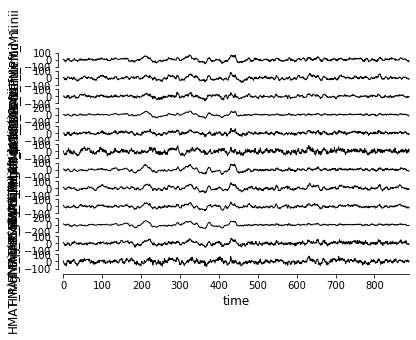

In [47]:
T, N = ts.shape 
dataframe = pp.DataFrame(ts, datatime = np.arange(len(ts)), var_names=label)
tp.plot_timeseries(dataframe);

In [48]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 50


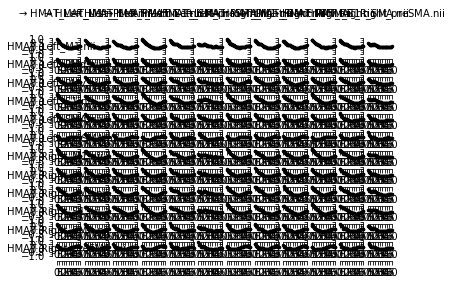

In [49]:
correlations = pcmci.get_lagged_dependencies(tau_max=50, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':label, 'x_base':5, 'y_base':.5})

In [50]:
TAU_MAX = 25
results = pcmci.run_pcmci(tau_max=TAU_MAX, pc_alpha=None)
#results = pcmci_cmi_knn.run_pcmci(tau_max=15, pc_alpha=0.1)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 25
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable HMAT_Left_M1.nii has 20 parent(s):
    [pc_alpha = 0.5]
        (HMAT_Left_M1.nii -2): max_pval = 0.00000, min_val =  0.265
        (HMAT_Right_PMv.nii -1): max_pval = 0.00000, min_val =  0.231
        (HMAT_Left_M1.nii -1): max_pval = 0.00000, min_val =  0.186
        (HMAT_Left_M1.nii -6): max_pval = 0.00035, min_val = -0.123
        (HMAT_Left_S1.nii -1): max_pval = 0.00132, min_val =  0.111
        (HMAT_Right_PMv.nii -2): max_pval = 0.00325, min_val =  0.102
        (HMAT_Right_M1.nii -1): max_pval = 0.05057, min_val =  0.068
        (HMAT_Right_S1.nii -4): max_pval = 0.16869, min_val =  0.048
        (HMAT_Left_PMv.nii -3): max_pval = 0.20510, min_val = -0.044
        (HMAT_Right_preSMA.nii -22): max_pval = 0.25670, min_

In [51]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
link_dict = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_dict']

p-values
[[[1.    0.    0.    ... 0.486 0.448 0.514]
  [0.    0.    0.209 ... 0.259 0.98  0.04 ]
  [0.    0.    0.476 ... 0.216 0.213 0.024]
  ...
  [0.    0.506 0.    ... 0.477 0.066 0.936]
  [0.    0.028 0.047 ... 0.164 0.256 0.495]
  [0.    0.    0.36  ... 0.338 0.876 0.26 ]]

 [[0.    0.043 0.    ... 0.499 0.407 0.936]
  [1.    0.    0.    ... 0.733 0.587 0.7  ]
  [0.    0.28  0.008 ... 0.186 0.615 0.91 ]
  ...
  [0.    0.445 0.018 ... 0.414 0.019 0.513]
  [0.    0.478 0.064 ... 0.505 0.181 0.752]
  [0.    0.001 0.002 ... 0.627 0.631 0.452]]

 [[0.    0.135 0.391 ... 0.622 0.207 0.578]
  [0.    0.797 0.098 ... 0.934 0.084 0.061]
  [1.    0.    0.106 ... 0.723 0.441 0.983]
  ...
  [0.    0.493 0.1   ... 0.477 0.06  0.872]
  [0.    0.754 0.002 ... 0.984 0.069 0.391]
  [0.    0.027 0.826 ... 0.392 0.718 0.111]]

 ...

 [[0.    0.041 0.103 ... 0.731 0.093 0.957]
  [0.    0.    0.075 ... 0.261 0.337 0.117]
  [0.    0.139 0.477 ... 0.177 0.18  0.449]
  ...
  [1.    0.    0.763 ... 0.841 

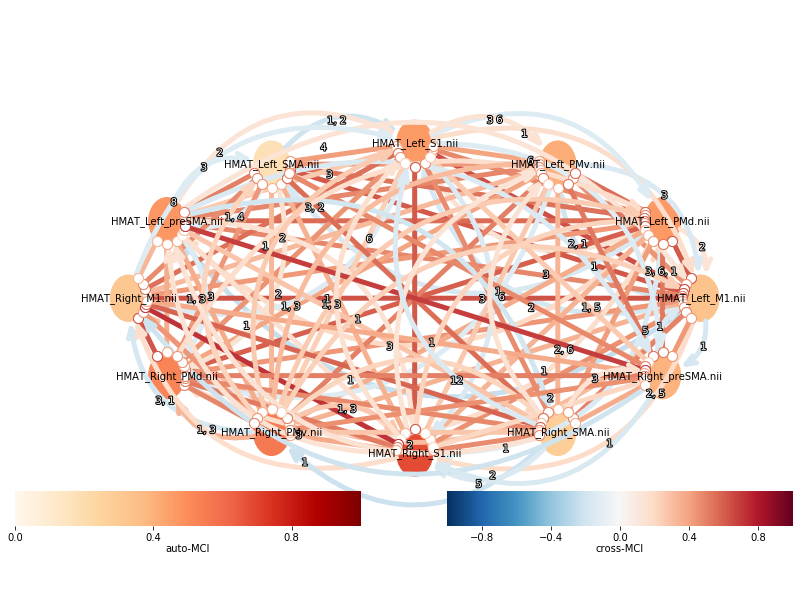

In [52]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=label,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    figsize=(12, 8),
    curved_radius=0.5,
    ); plt.show()

In [53]:
med = LinearMediation(dataframe=dataframe)
med.fit_model(all_parents=link_dict, tau_max=TAU_MAX)

print ("Average Causal Effect")
print(tuple(med.get_all_ace()))
print ("Average Causal Susceptibility")
print(tuple(med.get_all_acs()))
print ("Average Mediated Causal Effect")
print(tuple(med.get_all_amce()))

Average Causal Effect
(0.15806749414330476, 0.11221984761090385, 0.08169926556676957, 0.12449134545166553, 0.16219187386277614, 0.1524701620255624, 0.0063743032226906415, 0.06393441749479938, 0.44708258407944346, 0.1618586344895061, 0.20763448609220092, 0.05872815603489867)
Average Causal Susceptibility
(0.18979760280850239, 0.15645154487444873, 0.11827055636429239, 0.15429593906668368, 0.07329782207590989, 0.18726662875759914, 0.21355264533941887, 0.16306333536560305, 0.033906061425006025, 0.17675199193333543, 0.09746814013510866, 0.17263030192861323)
Average Mediated Causal Effect
(0.0652944932867847, 0.0223692145013838, 0.01817189961275243, 0.029977402099153446, 0.026432117752000536, 0.05017910338524253, 0.003919990604783962, 0.019911381412096626, 0.01651533953550898, 0.035729571025690986, 0.04095719268213426, 0.024345779577361372)
